## step1: Import

In [1]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import pandas as pd

## step2: Read Data, Normalization and split

In [2]:
df = pd.read_csv("./insurance.csv")
tags = ['age', 'bmi', 'children']
label = ['charges']

miny = df[label].min()
maxy = df[label].max()

df = df[tags+label]
df = (df - df.min(axis=0)) / (df.max(axis=0)- df.min(axis=0))

print(df)

x = np.array(df[tags])
y = np.array(df[label])

length = len(y)
trainLen = int(0.9*length)
XTrain = x[0: trainLen]
YTrain = y[0: trainLen]

XTest = x[trainLen: ]
YTest = y[trainLen: ]

# YTest

           age       bmi  children   charges
0     0.021739  0.321227       0.0  0.251611
1     0.000000  0.479150       0.2  0.009636
2     0.217391  0.458434       0.6  0.053115
3     0.326087  0.181464       0.0  0.333010
4     0.304348  0.347592       0.0  0.043816
...        ...       ...       ...       ...
1333  0.695652  0.403820       0.6  0.151299
1334  0.000000  0.429379       0.0  0.017305
1335  0.000000  0.562012       0.0  0.008108
1336  0.065217  0.264730       0.0  0.014144
1337  0.934783  0.352704       0.0  0.447249

[1338 rows x 4 columns]


## Step3: Create Network

### define neuronFunction
test different activation functions(Relu, Sigmoid)

In [3]:
class NeuronFunction:
    # 作用于神经元以修改各参数的函数
    def NFForward(self, input):
        # 由输入矩阵进行参数运算得到输出矩阵
        self.input = input
        self.output = self.NFSubOutput()   # 根据要求调用不同的激活函数
        return self.output
    
    def NFBackward(self, errorgrad):
        # 由后一损失梯度得到前一损失梯度
        return self.NFSubInputGrad(errorgrad) # 根据要求乘上不同的激活函数导数
    
class Sigmoid(NeuronFunction):
    # 与激活函数Sigmoid()相关的操作
    def NFSubOutput(self):
        return 1.0 / (1.0 + np.exp(-self.input))

    def NFSubInputGrad(self, errorgrad):
        return self.output * (1.0 - self.output) * errorgrad

class Relu(NeuronFunction):
    # 与激活函数Relu()相关的操作
    def NFSubOutput(self):
        # return 1.0 / (1.0 + np.exp(-self.input))
        return np.maximum(self.input, 0)


    def NFSubInputGrad(self, errorgrad):
        # return self.output * (1.0 - self.output) * errorgrad
        return np.maximum(errorgrad, 0)


class ParamFunction(NeuronFunction):
    # 将关于weight和bias的操作的超类也定义为NeuronFunction的子类，后续反向传播统一调用即可
    def __init__(self, param):
        self.param = param  # 增加变量param
    
    def NFBackward(self, errorgrad):
        self.paramgrad = self.PFSubParamGrad(errorgrad)
        return super().NFBackward(errorgrad)

class RegressionEnd(NeuronFunction):
    # 回归任务中，最后一层神经元不使用Sigmoid，需要特殊操作
    def NFSubOutput(self):
        return self.input   # 直接输出输入
    
    def NFSubInputGrad(self, errorgrad):
        return errorgrad   # 不做任何操作

class Weight(ParamFunction):
    # 与权重weight相关的操作
    def __init__(self, param):
        super().__init__(param)
    
    def NFSubOutput(self):
        return np.dot(self.input, self.param)
    
    def NFSubInputGrad(self, errorgrad):
        return np.dot(errorgrad, self.param.T)
    
    def PFSubParamGrad(self, errorgrad):
        return np.dot(self.input.T, errorgrad)

class Bias(ParamFunction):
    # 与偏置bias相关的操作
    def __init__(self, param):
        super().__init__(param)
    
    def NFSubOutput(self):
        return self.input + self.param
    
    def NFSubInputGrad(self, errorgrad):
        return errorgrad
    
    def PFSubParamGrad(self, errorgrad):
        return np.dot(np.ones((1, self.input.shape[0])), errorgrad)

### Define errorFunction

In [4]:
class Error:
    # 计算误差以调整优化参数
    def EForward(self, result, expected):
        # 由损失函数求出损失值
        self.result = result
        self.expected = expected
        return self.ESubOutput()    # 根据指定损失函数调用子类函数
    
    def EBackward(self):
        # 由输出值求出其对损失函数的梯度
        self.inputGrad = self.ESubInputGrad()
        return self.inputGrad
    
class MeanSquareError(Error):
    # 均方误差
    def ESubOutput(self):
        return (np.sum(np.power(self.result - self.expected, 2)) / self.result.shape[0])
    
    def ESubInputGrad(self):
        return (2.0 * (self.result - self.expected) / self.result.shape[0])

### Define NetLayer

In [5]:
import numpy as np

class Layer:
    # 神经网络层，对每一个网络层创建一个此类对象
    def __init__(self, quantity, activation):
        self.params = []
        self.neuronFunctions: list[NeuronFunction] = []
        self.established = False
        self.quantity = quantity
        self.activation = activation

    def LForward(self, input):
        # 由输入矩阵进行参数运算得到输出矩阵
        if self.established == False:
            # 初始化网络参数
            self.params = []
            self.params.append(np.random.randn(input.shape[1], self.quantity) * 0.1)
            self.params.append(-np.random.random((1, self.quantity)) * 0.1)
            self.neuronFunctions = [Weight(self.params[0]), Bias(self.params[1]), self.activation]
            self.established = True
        self.input = input
        for f in self.neuronFunctions:
            input = f.NFForward(input)
        self.output = input
        return self.output
    
    def LBackward(self, errorgrad):
        # 由后一损失梯度得到前一损失梯度
        for f in reversed(self.neuronFunctions):
            errorgrad = f.NFBackward(errorgrad)
        self.paramsgrads = []
        for f in self.neuronFunctions:
            # 本步只作用于与weight和bias有关的操作
            if issubclass(f.__class__, ParamFunction):
                self.paramsgrads.append(f.paramgrad)
        return errorgrad


### Define BPNetwork

In [6]:
class BPNetwork:
    # 构造BP网络
    def __init__(self, layers, error):
        self.layers: list[Layer] = layers
        self.error: Error = error
        self.Y0 = []
        self.Y1 = []
        self.Y2 = []
    
    def BPNForward(self, batch):
        # 前向传播
        for l in self.layers:
            batch = l.LForward(batch)
        return batch

    def BPNBackward(self, ErrorGrad):
        # 反向传播
        for l in reversed(self.layers):
            ErrorGrad = l.LBackward(ErrorGrad)
    
    def BPNBatchTrain(self, batch, expected):
        results = self.BPNForward(batch)
        error = self.error.EForward(results, expected)
        self.BPNBackward(self.error.EBackward())
        return error
    
    # 下面两个函数使用生成器，用于逐层优化网络参数
    def ParamsGenerator(self):
        for l in self.layers:
            yield from l.params
    
    def ParamGradsGenerator(self):
        for l in self.layers:
            yield from l.paramsgrads
    
    def BatchGenerator(self, x, y, BatchSize):
        # 使用生成器实现
        for i in range(0, x.shape[0], BatchSize):
            XBatch, YBatch = x[i:i+BatchSize], y[i:i+BatchSize]
            yield XBatch, YBatch
    
    def BPNTrain(self, XTrain, YTrain, epoches, interval, BatchSize, LearningRate):
        for e in range(epoches):
                
            if (e) % interval == 0:
                r = self.BPNForward(XTrain)
                er = self.error.EForward(r, YTrain)
                self.Y0.append(er)
                # results = self.BPNForward(XTest)
                # error = self.error.EForward(results, YTest)

                print(f"\repoch: {e}/{epoches}, error = {er}\r", end="")

            shuffle = np.random.permutation(XTrain.shape[0])    # 打乱顺序
            XTrain, YTrain = XTrain[shuffle], YTrain[shuffle]
            for XBatch, YBatch in self.BatchGenerator(XTrain, YTrain, BatchSize):
                self.BPNBatchTrain(XBatch, YBatch)
                for (param, paramGrad) in zip(self.ParamsGenerator(), self.ParamGradsGenerator()):
                    param -= LearningRate * paramGrad
    
    def BPNPredict(self, classify, XTest, YTest, cr=[]):
        if classify:
            results = self.BPNForward(XTest)
            accuracy = np.equal(np.argmax(results, axis=1), cr).sum() / cr.shape[0]
            self.Y2.append(accuracy)
            print(f"accuracy: {accuracy}")


## step4: Create Network Instance and Train

In [7]:

bpn2 = BPNetwork([ Layer(8, Sigmoid()), Layer(1, RegressionEnd())], MeanSquareError())
bpn2.BPNTrain(XTrain, YTrain, epoches=20000, interval=40, BatchSize=40, LearningRate=0.001)



## step5: Save the Model

In [8]:

with open('xzymodel.pkl', 'wb') as f:
    pickle.dump(bpn2, f)

## step6: Load and Test

relative error: 0.03825669560824202
[[0.         0.30454668 0.6        0.10932462 0.27297641]
 [0.36956522 0.05111649 0.2        0.1275469  0.06376247]
 [0.89130435 0.50686037 0.4        0.29054139 0.57126193]
 [0.39130435 0.46919559 0.4        0.19725441 0.59528269]
 [0.41304348 0.25813828 0.2        0.16465678 0.30607234]
 [0.89130435 0.56873823 0.2        0.29174985 0.17917889]
 [0.39130435 0.40126446 0.2        0.18063653 0.06786255]
 [0.45652174 0.48802798 0.4        0.21163107 0.35820687]
 [0.         0.14823783 0.         0.06512171 0.00926728]
 [0.73913043 0.46650525 0.4        0.25890178 0.154592  ]
 [0.19565217 0.41148776 0.2        0.14614373 0.04523963]
 [0.         0.6236212  0.         0.13251088 0.18784446]
 [0.47826087 0.24535916 0.         0.1675107  0.06853769]
 [0.23913043 0.57384988 0.4        0.18406629 0.04686848]
 [0.60869565 0.50147969 0.2        0.23357303 0.64709759]]


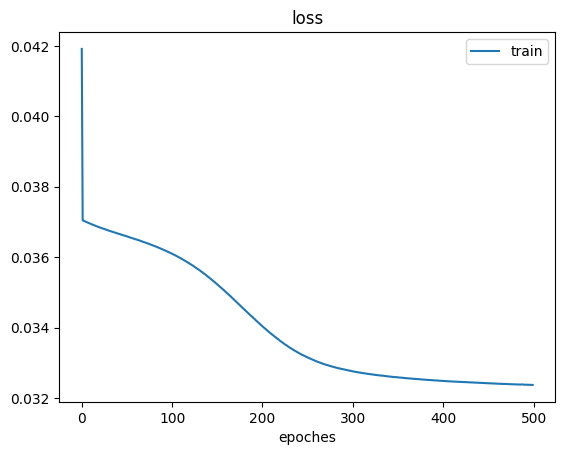

In [9]:
with open('xzymodel.pkl', 'rb') as f:
    bpn2 = pickle.load(f)

YPred = bpn2.BPNForward(XTest)

mse_err = np.mean((YTest - YPred) ** 2)
print(f"relative error: {mse_err}")


maxy, miny = np.array(maxy), np.array(miny)
YPred = YPred * (maxy - miny) + miny
YTestp = YTest * (maxy - miny) + miny

Yprint = np.hstack((YPred, YTest))
printA = np.hstack((XTest, Yprint))
print(printA[: 15])

plt.title('loss')
plt.xlabel('epoches')
plt.plot(bpn2.Y0, label='train')
plt.legend()
plt.savefig('./final.jpg')
